In [2]:
import matplotlib.pyplot as plt

import torch
from pyro.infer import Predictive


from cities.modeling.model_interactions import model_cities_interaction
from cities.modeling.model_interactions import InteractionsModel

In [3]:
# outcome_dataset= 'industry_transportation_warehousing_total'
# intervention_dataset='spending_transportation'
# forward_shift = 3

outcome_dataset = "unemployment_rate"
intervention_dataset = "spending_commerce"
forward_shift = 2

[iteration 0001] loss: 144320.5903
[iteration 0101] loss: 2316.1030
[iteration 0201] loss: -95320.8440
[iteration 0301] loss: -124133.8781
[iteration 0401] loss: -131363.2988
[iteration 0501] loss: -133743.5740
[iteration 0601] loss: -134560.0364
[iteration 0701] loss: -133130.8574
[iteration 0801] loss: -134149.4067
[iteration 0901] loss: -134749.6305


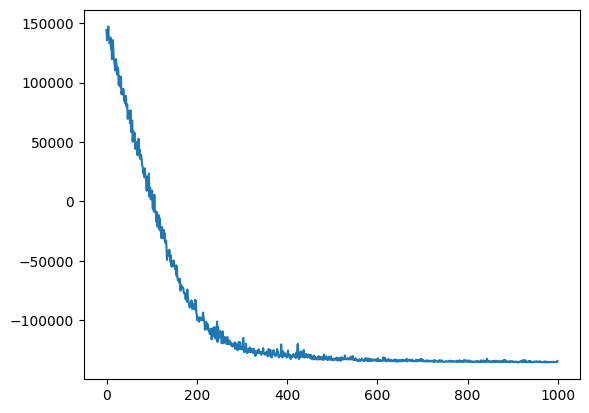

In [4]:
im_source = InteractionsModel(
    outcome_dataset=outcome_dataset,
    intervention_dataset=intervention_dataset,
    forward_shift=forward_shift,
    num_iterations=1000,
    num_samples=1000,
    plot_loss=True,
)

im_source.train_interactions_model()

im_source.sample_from_guide()

im_source.save_guide()

In [9]:
predictive = Predictive(
    model=model_cities_interaction,
    guide=im_source.guide,
    num_samples=1000,
    parallel=False,
)
samples = predictive(*im_source.model_args)

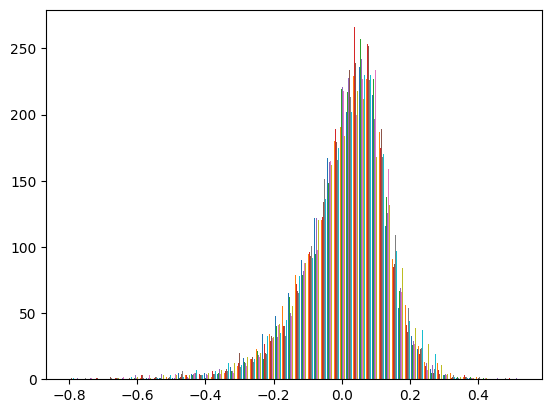

In [10]:
# plot residuals
predictions = samples["Y"].squeeze()
average_predictions = torch.mean(predictions, dim=0)
plt.hist(average_predictions - im_source.data["y"].squeeze(), bins=70)
plt.show()

tensor(-0.0017)
tss tensor(755.8540)
torch.Size([30740])
rss tensor(484.7957)
r_squared tensor(0.3586)


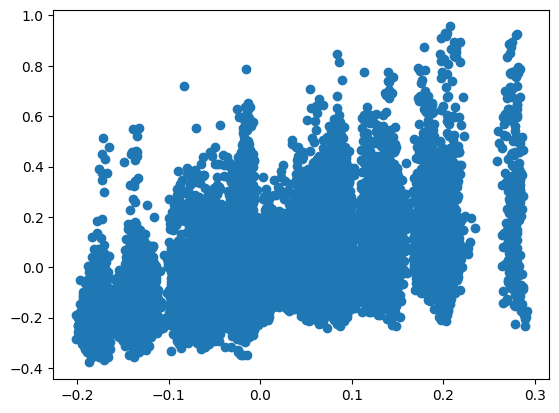

In [11]:
y_flat = im_source.data["y"].view(-1)

observed_mean = torch.mean(y_flat)
print(observed_mean)

tss = torch.sum((y_flat - observed_mean) ** 2)
print("tss", tss)

average_predictions_flat = average_predictions.view(-1)
print(average_predictions_flat.shape)

plt.scatter(average_predictions_flat, y_flat)

rss = torch.sum((y_flat - average_predictions_flat) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

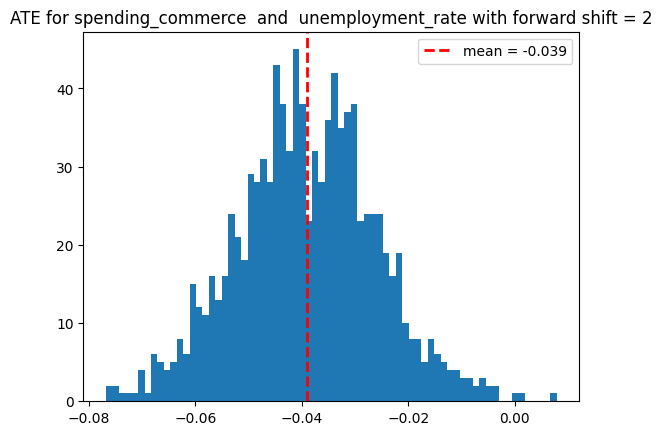

In [12]:
tau_samples = samples["weight_TY"].squeeze().detach().numpy()

plt.hist(tau_samples, bins=70)
plt.axvline(
    x=tau_samples.mean(),
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"mean = {tau_samples.mean():.3f}",
)
plt.title(
    f"ATE for {intervention_dataset}  and  {outcome_dataset} with forward shift = {forward_shift}"
)
plt.legend()
plt.show()